In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
df = pd.read_csv("../input/online-retail-ii-uci/online_retail_II.csv")

In [ ]:
df.head()

In [ ]:
df.isna().sum()

In [ ]:
df.info()

In [ ]:
df.shape

In [ ]:
df.dropna(inplace = True)

In [ ]:
#fatura basina ortalama kac para kazanilmistir? (iki değişkeni çarparak yeni bir değişken oluşturmak gerekmektedir)
df["TotalPrice"] = df["Quantity"]*df["Price"]

In [ ]:
df.describe([0.01,0.05,0.10,0.25,0.50,0.75,0.90,0.95, 0.99]).T

In [ ]:
for feature in ["Quantity","Price","TotalPrice"]:

    Q1 = df[feature].quantile(0.01)
    Q3 = df[feature].quantile(0.99)
    IQR = Q3-Q1
    upper = Q3 + 1.5*IQR
    lower = Q1 - 1.5*IQR

    if df[(df[feature] > upper) | (df[feature] < lower)].any(axis=None):
        print(feature,"yes")
        print(df[(df[feature] > upper) | (df[feature] < lower)].shape[0])
    else:
        print(feature, "no")

In [ ]:
df.head()

In [ ]:
df[["InvoiceDate"]] = df[["InvoiceDate"]].apply(pd.to_datetime)

In [ ]:
df.info()

In [ ]:
df["InvoiceDate"].min()

In [ ]:
df["InvoiceDate"].max()

In [ ]:
import datetime as dt
today_date = dt.datetime(2010,12,9)

In [ ]:
df["Customer ID"] = df["Customer ID"].astype(int)

In [ ]:
#Evet şimdi ne yapmamız lazım? 

#Her bir müşteri için bugünün tarihinden müşterilerin son satın alma tarihini çıkarmamız lazım.

#Tekilleşmiş müşteri son tarihleri elimizde öyleyse 

In [ ]:
(today_date - df.groupby("Customer ID").agg({"InvoiceDate":"max"})).head()

In [ ]:
temp_df = (today_date - df.groupby("Customer ID").agg({"InvoiceDate":"max"}))

In [ ]:
temp_df.rename(columns={"InvoiceDate": "Recency"}, inplace = True)

In [ ]:
temp_df

In [ ]:
recency_df = temp_df["Recency"].apply(lambda x: x.days)

In [ ]:
recency_df.head()

# Frequency

In [ ]:
temp_df = df.groupby(["Customer ID","Invoice"]).agg({"Invoice":"count"})

In [ ]:
temp_df.head()

In [ ]:
temp_df.groupby("Customer ID").agg({"Invoice":"count"})

In [ ]:
freq_df = temp_df.groupby("Customer ID").agg({"Invoice":"count"})
freq_df.rename(columns={"Invoice": "Frequency"}, inplace = True)
freq_df.head()

# Monetary

In [ ]:
monetary_df = df.groupby("Customer ID").agg({"TotalPrice":"sum"})

In [ ]:
monetary_df.head()

In [ ]:
monetary_df.rename(columns={"TotalPrice": "Monetary"}, inplace = True)

In [ ]:
print(recency_df.shape,freq_df.shape,monetary_df.shape)

In [ ]:
rfm = pd.concat([recency_df, freq_df, monetary_df],  axis=1)

In [ ]:
rfm.head()

In [ ]:
pd.qcut(rfm['Frequency'], 6,labels = [1, 2, 3, 4,5],duplicates='drop').value_counts()

In [ ]:
rfm["RecencyScore"] = pd.qcut(rfm['Recency'], 5, labels = [5, 4, 3, 2, 1])
rfm["FrequencyScore"] = pd.qcut(rfm['Frequency'], 6,labels = [1, 2, 3, 4,5],duplicates='drop')
#rfm["FrequencyScore"] = pd.qcut(rfm['Frequency'], 5, labels = [1, 2, 3, 4, 5])
rfm["MonetaryScore"] = pd.qcut(rfm['Monetary'], 5, labels = [1, 2, 3, 4, 5])

In [ ]:
rfm.head()

In [ ]:
(rfm['RecencyScore'].astype(str) + 
 rfm['FrequencyScore'].astype(str) + 
 rfm['MonetaryScore'].astype(str)).head()

In [ ]:
rfm["RFM_SCORE"] = rfm['RecencyScore'].astype(str) + rfm['FrequencyScore'].astype(str) + rfm['MonetaryScore'].astype(str)

In [ ]:
rfm.head()

In [ ]:
rfm.describe().T

In [ ]:
rfm[rfm["RFM_SCORE"] == "555"].head()

In [ ]:
rfm[rfm["RFM_SCORE"] == "111"].head()

In [ ]:
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Loose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

In [ ]:
rfm['Segment'] = rfm['RecencyScore'].astype(str) + rfm['FrequencyScore'].astype(str)
rfm['Segment'] = rfm['Segment'].replace(seg_map, regex=True)
rfm.head()

In [ ]:
rfm[["Segment", "Recency","Frequency","Monetary"]].groupby("Segment").agg(["mean","count"])

In [ ]:
rfm[rfm["Segment"] == "Need Attention"].head()

In [ ]:
rfm[rfm["Segment"] == "New Customers"].index

In [ ]:
new_df = pd.DataFrame()
new_df["NewCustomerID"] = rfm[rfm["Segment"] == "New Customers"].index

In [ ]:
new_df.head()

In [ ]:
new_df.to_csv("new_customers.csv")

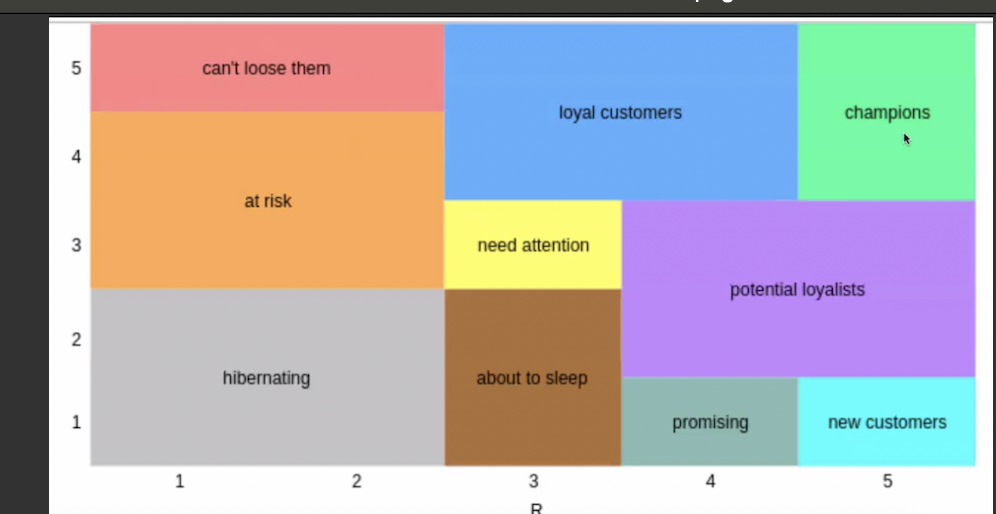
